In [45]:
import random
import time
import pandas as pd
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [0]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
#from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
import io

**ASSIGNMENT QUESTIONS**

1. Read the column description and ensure you understand each attribute well
2. Study the data distribution in each attribute, share your findings. (5 points)
3. Get the target column distribution. Your comments
4. Split the data into training and test set in the ratio of 70:30 respectively
5. Use different classification models (Logistic, K-NN and Naïve Bayes) to predict the likelihood of a liability customer buying personal loans (15 points)
6. *Print* the confusion matrix for all the above models (5 points)
7. Give your reasoning on which is the best model in this case and why it performs better? (5 points)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
file = '/content/drive/My Drive/PGML/supervisedlearning/Bank_Personal_Loan_Modelling-1.csv'
df = pd.read_csv(file)
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [9]:
df.shape

(5000, 14)

In [0]:
## ID column has nothing to do with the prediction so droping this column

df = df.drop('ID',axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


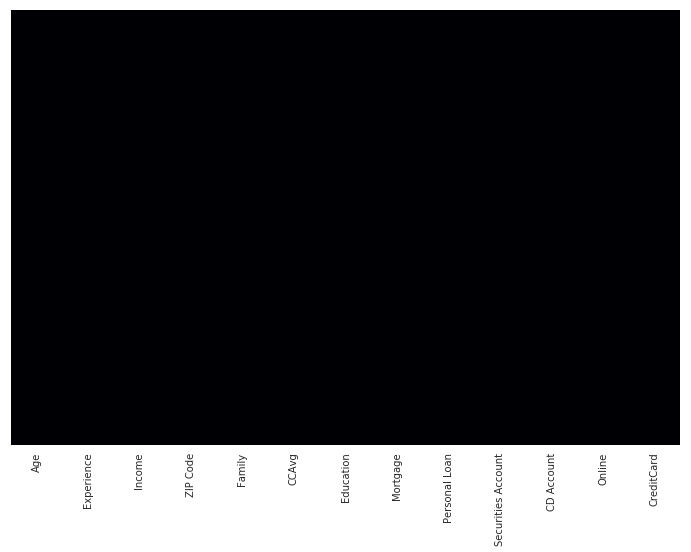

In [15]:
## finding the null and missing values in the database
sns.heatmap(df.isnull(),xticklabels=True,yticklabels=False,cbar=False,cmap='inferno')

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.0,93437.0,94608.0,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0
Securities Account,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0



**1. Age - min and max values lies within IQR , uppper and lower limit so we don't have any outlayers. Major customers lies in the age group greater than 30 means majority of them are from working group and retired group(in majortiy).**

**2. Experience - min value is in negative which could not be possible so either we will make then zero or adjust with the bucketing method. We have customers with experiences of min 1 to max 45 yrs.**

**3. Income - shows 75% at 98 while the max values is 224 , it is slightly right skewed.SO most customers we can say belong to middle and upper class**

**4. Zip code- its the representation of of the customer location**

**5. Family size - categorocal value - values are 1,2,3,4**

**6. CCAvg  - almost symmetric distribution of data. Skewed towards right so majority of customers belong to group having average credit card usage as $1500 means their financial status is average and above.** 

**7. Educatuion - categorocal value - 1: Undergrad; 2: Graduate; 3: Advanced/Professional**

**8. Mortgage - Moajority of customers dont't have  mortgage value and only few have mortgage value equal and above $100000.  Customers in majority represents their own house**

**9. Personal Loan	- categorocal value - 1 and 0 - Target column**

**10. Securities Account	-categorocal value - 1 and 0**

**11. CD Account-	categorocal value - 1 and 0**

**12. Online	-categorocal value - 1 and 0**

**13. CreditCard-categorocal value - 1 and 0**

In [18]:
## now will see the distribution of data for each column
df['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

In [0]:
##  our target is an example of Class Imblanace where one class of customers whcih accepted the loan is in minority while other class is in majority. We need to use 
##  technique like smote or near miss to  remove this imbalance in the classes in our targte column

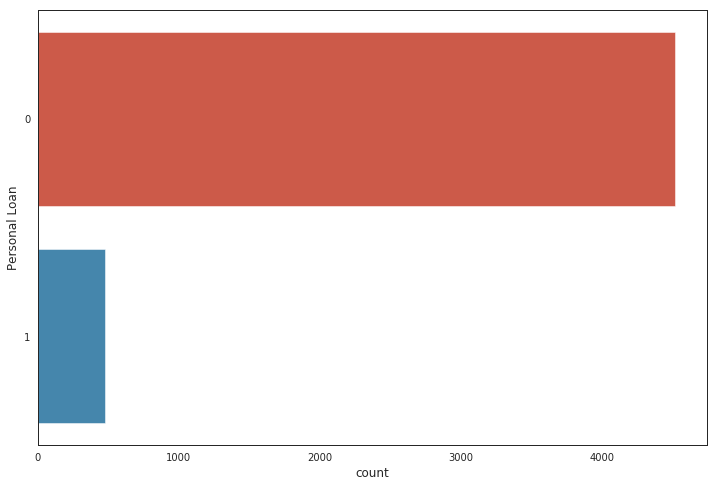

In [19]:
sns.countplot(y=df['Personal Loan'])


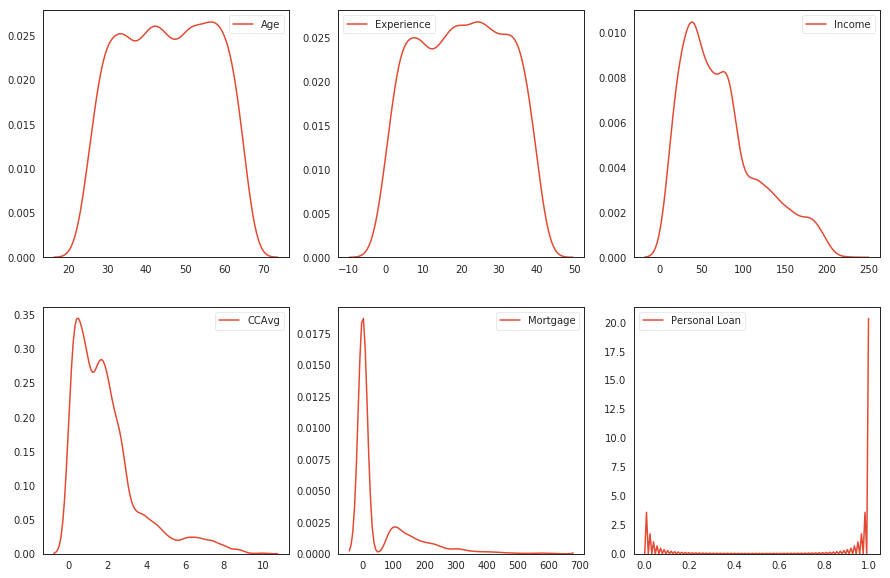

In [21]:
fig, qaxis = plt.subplots(2,3,figsize=(15,10))

sns.kdeplot(df['Age'], ax = qaxis[0,0])
#axis1.set_title('')

sns.kdeplot(df['Experience'], ax = qaxis[0,1])

sns.kdeplot(df['Income'], ax = qaxis[0,2])


sns.kdeplot(df['CCAvg'], ax = qaxis[1,0])


sns.kdeplot(df['Mortgage'], ax = qaxis[1,1])

sns.kdeplot(df['Personal Loan'], ax = qaxis[1,2])



## OBSERVATION ##

1. Age columns has three sub distribution indcating three age intervals
2. Experience has two sub clusters with second distribution more towrds higher education
3. Income is right skewed showing mid range and low ragnge income classes more
4. Avg. spending on credit cards per month ($000) is more towards lower range 
5. *Value* of house mortgage is showing normal distribution with major outliers at higher range.

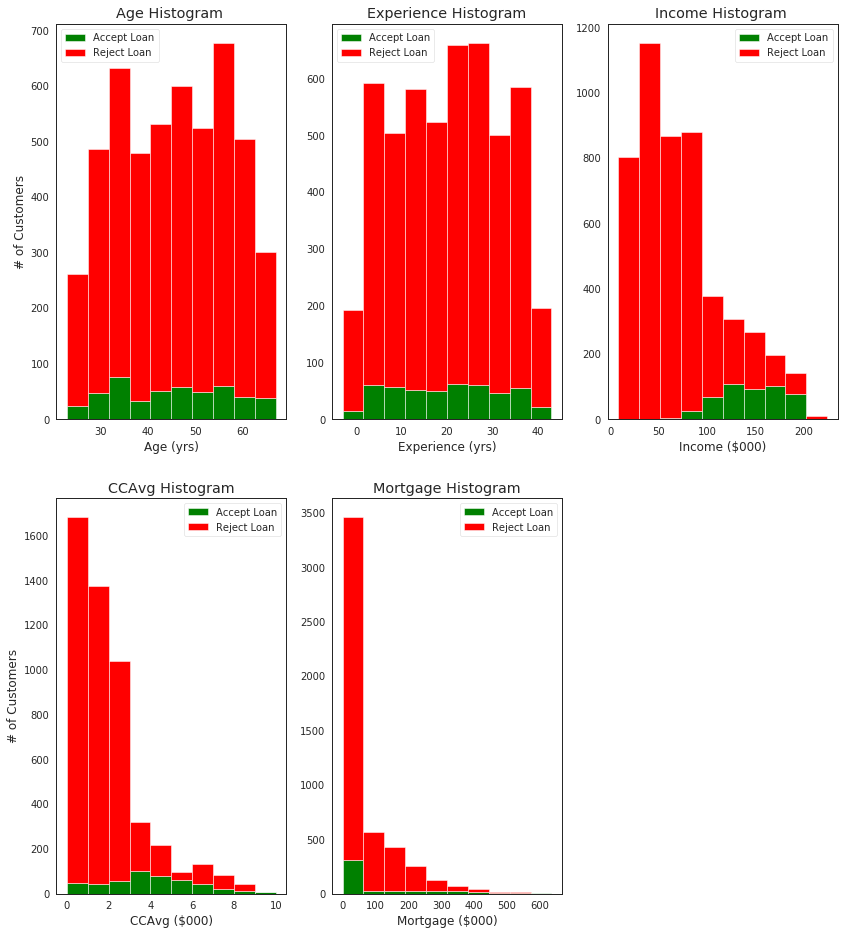

In [24]:
#graph distribution of quantitative data vs Personal Loan
plt.figure(figsize=[14,16])


plt.subplot(231)
plt.hist(x = [df[df['Personal Loan']==1]['Age'], df[df['Personal Loan']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Accept Loan','Reject Loan'])
plt.title('Age Histogram ')
plt.xlabel('Age (yrs)')
plt.ylabel('# of Customers')
plt.legend()

plt.subplot(232)
plt.hist(x = [df[df['Personal Loan']==1]['Experience'], df[df['Personal Loan']==0]['Experience']], 
         stacked=True, color = ['g','r'],label = ['Accept Loan','Reject Loan'])
plt.title('Experience Histogram')
plt.xlabel('Experience (yrs)')
#plt.ylabel('# of Customers')
plt.legend()


plt.subplot(233)
plt.hist(x = [df[df['Personal Loan']==1]['Income'], df[df['Personal Loan']==0]['Income']], 
         stacked=True, color = ['g','r'],label = ['Accept Loan','Reject Loan'])
plt.title('Income Histogram ')
plt.xlabel('Income ($000)')
#plt.ylabel('# of Customers')
plt.legend()


plt.subplot(234)
plt.hist(x = [df[df['Personal Loan']==1]['CCAvg'], df[df['Personal Loan']==0]['CCAvg']], 
         stacked=True, color = ['g','r'],label = ['Accept Loan','Reject Loan'])
plt.title('CCAvg Histogram')
plt.xlabel('CCAvg ($000)')
plt.ylabel('# of Customers')
plt.legend()


plt.subplot(235)
plt.hist(x = [df[df['Personal Loan']==1]['Mortgage'], df[df['Personal Loan']==0]['Mortgage']], 
         stacked=True, color = ['g','r'],label = ['Accept Loan','Reject Loan'])
plt.title('Mortgage Histogram')
plt.xlabel('Mortgage ($000)')
#plt.ylabel('# of Customers')
plt.legend()



In [0]:
# AGE - there is the equal distrbution of Loan accepting customers in all class intervals however maority of  Loan accepting customers are present
# in the 30 - 40 age interval
# Experience - there is the equal distrbution of Loan accepting customers in all class intervals
# Income($000)- there is the assymetric distrbution of Loan accepting customers in all class intervals.Majority are from $100000 to $200000
# Credi Card Average($000)- there is the equal distrbution of Loan accepting customers in all class intervals however maority of  Loan accepting customers are present in the $2000-$4000 interval
# Mortgage - if we look fot the distrbution of Loan accepting customers we will find majority of  Loan accepting customers lies below mortgage value less than $ 100000

In [29]:
df['AgeBin'] = pd.cut(df['Age'],7)
print(df['AgeBin'].unique())

grp = df.groupby('AgeBin')
print(grp['Age'].count().sum())
print(grp['Age'].count())

[(22.956, 29.286], (41.857, 48.143], (35.571, 41.857], (29.286, 35.571], (48.143, 54.429], (60.714, 67.0], (54.429, 60.714]]
Categories (7, interval[float64]): [(22.956, 29.286] < (29.286, 35.571] < (35.571, 41.857] <
                                    (41.857, 48.143] < (48.143, 54.429] < (54.429, 60.714] <
                                    (60.714, 67.0]]
5000
AgeBin
(22.956, 29.286]    488
(29.286, 35.571]    786
(35.571, 41.857]    722
(41.857, 48.143]    881
(48.143, 54.429]    782
(54.429, 60.714]    794
(60.714, 67.0]      547
Name: Age, dtype: int64


In [32]:
df['IncomeBin'] = pd.qcut(df['Income'],10)
print(df['IncomeBin'].unique())

grp = df.groupby('IncomeBin')
print(grp['Income'].count().sum())
print(grp['Income'].count())

[(42.0, 52.0], (33.0, 42.0], (7.999, 22.0], (88.3, 113.0], (22.0, 33.0], (64.0, 78.0], (78.0, 88.3], (145.0, 224.0], (113.0, 145.0], (52.0, 64.0]]
Categories (10, interval[float64]): [(7.999, 22.0] < (22.0, 33.0] < (33.0, 42.0] < (42.0, 52.0] < ... <
                                     (78.0, 88.3] < (88.3, 113.0] < (113.0, 145.0] <
                                     (145.0, 224.0]]
5000
IncomeBin
(7.999, 22.0]     507
(22.0, 33.0]      522
(33.0, 42.0]      520
(42.0, 52.0]      453
(52.0, 64.0]      548
(64.0, 78.0]      469
(78.0, 88.3]      481
(88.3, 113.0]     521
(113.0, 145.0]    495
(145.0, 224.0]    484
Name: Income, dtype: int64


In [35]:
df['ExperienceBin'] = pd.cut(df['Experience'],6)
print(df['ExperienceBin'].unique())

grp = df.groupby('ExperienceBin')
print(grp['Experience'].count().sum())
print(grp['Experience'].count())

[(-3.046, 4.667], (12.333, 20.0], (4.667, 12.333], (20.0, 27.667], (35.333, 43.0], (27.667, 35.333]]
Categories (6, interval[float64]): [(-3.046, 4.667] < (4.667, 12.333] < (12.333, 20.0] <
                                    (20.0, 27.667] < (27.667, 35.333] < (35.333, 43.0]]
5000
ExperienceBin
(-3.046, 4.667]      519
(4.667, 12.333]      988
(12.333, 20.0]      1035
(20.0, 27.667]       913
(27.667, 35.333]    1031
(35.333, 43.0]       514
Name: Experience, dtype: int64


In [0]:
#code categorical data
label = LabelEncoder()
df['AgeBin_Code'] = label.fit_transform(df['AgeBin'])
df['ExperienceBin_Code'] = label.fit_transform(df['ExperienceBin'])
df['IncomeBin_Code'] = label.fit_transform(df['IncomeBin'])

In [40]:
data_train_dummy = pd.get_dummies(data = df,columns=['Family','Education','Securities Account','CD Account','Online','CreditCard'],dummy_na=False)
data_train_dummy.sample(2)

,Age,Experience,Income,ZIP Code,CCAvg,Mortgage,Personal Loan,AgeBin,IncomeBin,ExperienceBin,AgeBin_Code,ExperienceBin_Code,IncomeBin_Code,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3,Securities Account_0,Securities Account_1,CD Account_0,CD Account_1,Online_0,Online_1,CreditCard_0,CreditCard_1
4506,39,13,89,92037,2.8,153,0,"(35.571, 41.857]","(88.3, 113.0]","(12.333, 20.0]",2,2,7,1,0,0,0,0,0,1,1,0,1,0,0,1,0,1
2380,40,16,50,92606,0.6,0,0,"(35.571, 41.857]","(42.0, 52.0]","(12.333, 20.0]",2,2,3,0,1,0,0,0,0,1,1,0,1,0,1,0,1,0


In [41]:
data_train_dummy = data_train_dummy.drop(columns=['Age','Experience','ZIP Code','Income','AgeBin','IncomeBin','ExperienceBin'],axis=1) 
data_train_dummy.sample(2)

,CCAvg,Mortgage,Personal Loan,AgeBin_Code,ExperienceBin_Code,IncomeBin_Code,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3,Securities Account_0,Securities Account_1,CD Account_0,CD Account_1,Online_0,Online_1,CreditCard_0,CreditCard_1
1186,1.2,0,0,6,5,3,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0
1939,0.2,0,0,5,4,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0


In [0]:
data_train_dummy.drop(columns=['Personal Loan'],axis=1,inplace=True)

In [0]:
X = np.array(data_train_dummy)
Y=np.array(df['Personal Loan'])

In [0]:
  
MLA = [
                                  

          #Gaussian Processes                                            
          gaussian_process.GaussianProcessClassifier(),                  

          #GLM                                                           
          linear_model.LogisticRegressionCV(),                           
                                       

          #Navies Bayes                                                  
          naive_bayes.BernoulliNB(),                                     
          naive_bayes.GaussianNB(),                                      

          #Nearest Neighbor                                              
          neighbors.KNeighborsClassifier()                          

                                         
    ]

In [0]:
MLA_columns = ['MLA_Name']
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [0]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(X, Y, test_size=0.3,random_state = 0,shuffle = True, stratify = Y)
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_sample(train1_x,train1_y)

In [50]:
MLA_predict = pd.DataFrame({"Actual_Data_Target":test1_y})  
MLA_predict.head(2)

,Actual_Data_Target
0,1
1,0


In [0]:
row_index = 0
for alg in MLA:
    

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA_Name'] = MLA_name
    #MLA_compare.loc[row_index, 'MLA_Parameters'] = str(alg.get_params())   
 
    d = alg.fit(X_train_sm, y_train_sm)
    MLA_predict[MLA_name] = alg.predict(test1_x)
    #MLA_compare.loc[row_index, 'MLA_Intercept'] =  alg.intercept_
    MLA_compare.loc[row_index, 'Actual_Y_Shape'] =test1_y.shape
    MLA_compare.loc[row_index, 'confusion_matrix'] = str(metrics.confusion_matrix(test1_y,alg.predict(test1_x)))
    MLA_compare.loc[row_index, 'accuracy_score'] = metrics.accuracy_score(test1_y,alg.predict(test1_x))
    confusion_matrix = metrics.confusion_matrix(test1_y,alg.predict(test1_x))
    MLA_compare.loc[row_index, 'True_Positive_Rate\n[Sensitivity/Recall]'] = confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])
    MLA_compare.loc[row_index, 'Precision'] = confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])
    MLA_compare.loc[row_index, 'True_Negatve_Rate\n[Specificity]'] = confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1])    
    MLA_compare.loc[row_index, 'mean_absolute_error'] = metrics.mean_absolute_error(test1_y, alg.predict(test1_x))
    MLA_compare.loc[row_index, 'mean_squared_error'] = metrics.mean_squared_error(test1_y, alg.predict(test1_x))
    MLA_compare.loc[row_index, 'root_mean_squared_error'] = np.sqrt(metrics.mean_squared_error(test1_y, alg.predict(test1_x)))
    #MLA_compare.loc[row_index, 'explained_variance_score'] = explained_variance_score(test1_y, alg.predict(test1_x))
    
    
    
    row_index+=1

In [52]:
MLA_compare.sort_values(by = ['accuracy_score','Precision'], ascending = False, inplace = True)
MLA_compare

,MLA_Name,Actual_Y_Shape,confusion_matrix,accuracy_score,True_Positive_Rate [Sensitivity/Recall],Precision,True_Negatve_Rate [Specificity],mean_absolute_error,mean_squared_error,root_mean_squared_error
0,GaussianProcessClassifier,1500.0,[[1269 87]\n [ 24 120]],0.926000,0.935841,0.981439,0.833333,0.074000,0.074000,0.272029
3,GaussianNB,1500.0,[[1261 95]\n [ 32 112]],0.915333,0.929941,0.975251,0.777778,0.084667,0.084667,0.290975
4,KNeighborsClassifier,1500.0,[[1242 114]\n [ 18 126]],0.912000,0.915929,0.985714,0.875000,0.088000,0.088000,0.296648
1,LogisticRegressionCV,1500.0,[[1237 119]\n [ 14 130]],0.911333,0.912242,0.988809,0.902778,0.088667,0.088667,0.297769
2,BernoulliNB,1500.0,[[1088 268]\n [ 81 63]],0.767333,0.802360,0.930710,0.437500,0.232667,0.232667,0.482355


No handles with labels found to put in legend.


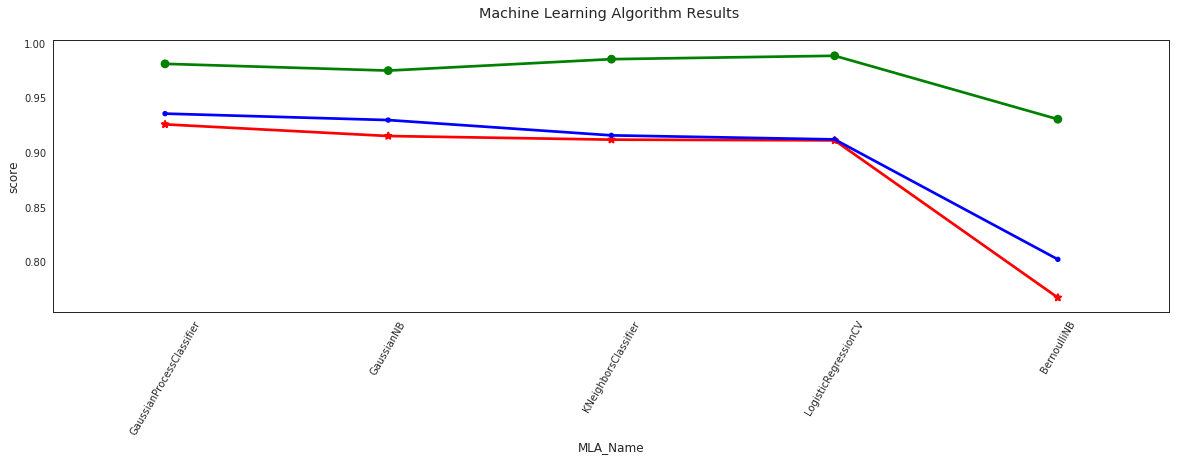

In [53]:
plt.figure(figsize=(20,5))
sns.pointplot(y='accuracy_score', x ='MLA_Name', data = MLA_compare , color = 'r',markers=["*"],label = 'accuracy_score')
sns.pointplot(y='Precision', x ='MLA_Name', data = MLA_compare , color = 'g',markers=["o"],label = 'Precision')
sns.pointplot(y='True_Positive_Rate\n[Sensitivity/Recall]', x ='MLA_Name', data = MLA_compare , color = 'blue',markers=["."],label = 'Recall')
plt.title('Machine Learning Algorithm Results \n')
plt.xlabel('MLA_Name')
plt.ylabel('score')
plt.xticks(rotation=60)
plt.legend(loc='bottom left', frameon=False)


Text(0, 0.5, 'Algorithm')

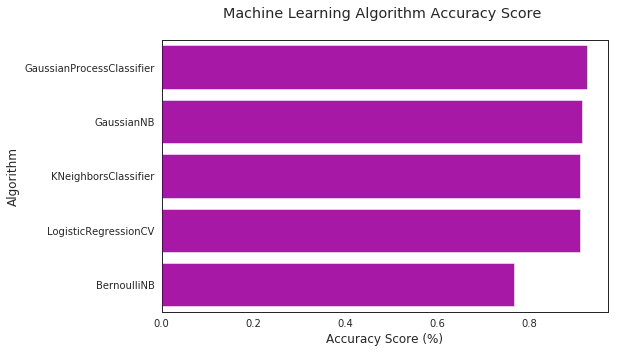

In [55]:
plt.figure(figsize=(8,5))

sns.barplot(x='accuracy_score', y ='MLA_Name', data = MLA_compare , color = 'm')
#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')


# Conclusion #
### the model will be good which have high accuracy score, precision score and recall value and minimum RMSE.
### so GaussianProcessClassifier is the best classification algorithm